In [1]:
# Import sys, then tell python where to find the nEXO-specific classes
# I'll assume you're in the sensitivity/work directory, as shown here by !pwd

import sys
!pwd
sys.path.append('../../../modules')

/g/g20/lenardo1/nEXO/sensitivity/work/SensitivityPaper2020_scripts/Rn222Study


In [2]:
# Import useful libraries for analysis

import pandas as pd
import histlite as hl
import numpy as np
from matplotlib import pyplot as plt
import os
import time

plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = (10,8)

from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
# Import the nEXO sensitivity classes

import nEXOFitWorkspace
import nEXOFitModel
import nEXOFitLikelihood

import importlib

importlib.reload( nEXOFitWorkspace )
importlib.reload( nEXOFitModel )
importlib.reload( nEXOFitLikelihood )

<module 'nEXOFitLikelihood' from '../../../modules/nEXOFitLikelihood.py'>

# Asimov sets

The "Asimov set" is defined in Cowan 2011 (https://arxiv.org/abs/1007.1727) as:

"*When one uses it to evaluate the estimators for all parameters, one obtains the true parameter values.*"

While it may or may not be unique, they show that this can be obtained by simply setting the value in each bin to its expectation value, which is simply the sum of the value of all background component PDFs and signal PDF in that bin. 

The claim is that then one can simply use this dataset to evaluate the sensitivity without needing to run lots of Monte Carlo datasets and taking the median. 

Ako also found a nice paper that compares the projected sensitivity for a counting experiment when using the Asimov sets vs. using the median of a Monte Carlo distribution:
(https://arxiv.org/abs/2009.07249)

## In our sensitivity calculations

In our case, it seems like this may enable us to forego the hypothesis scans, which can be pretty time consuming. Let's see how well this works if we compare the sensitivity obtained from the Asimov set with the sensitivity obtained via the MC. For a representative case, we'll first look at the D-023 model without the Rn222 component scaled by 1.

### First, compute sensitivity in the normal way



In [4]:
category = '01.0x'

outputdir = '/p/lustre2/lenardo1/sensitivity_output/Dec29_Rn222Study_merged-v10b_OptimizedV1Binning/'

all_files = os.listdir(outputdir)
h5_files = [filename for filename in all_files if filename.endswith('.h5')]

start_time = time.time()

print('Loading data for {}'.format(category))
df_list = [pd.read_hdf(outputdir+filename) for filename in h5_files if '_'+category+'_' in filename]
df = pd.concat(df_list,ignore_index=True)
print('---> Loaded {} toy datasets at {:4.4} min'.format(len(df),\
                                                         (time.time()-start_time)/60.))


Loading data for 01.0x
---> Loaded 2500 toy datasets at 0.235 min


In [5]:
df.head()

,90CL_crossing,best_fit_converged,best_fit_covar,best_fit_iterations,fixed_fit_acc_covar,fixed_fit_converged,lambda,num_iterations,num_signal
0,6.480648,True,True,2,"[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...","[0.00025047888056217715, 0.7327501243567092, 1...","[2.0, 1.0, 2.0, 3.0, 4.0, 3.0, 2.0, 1.0, 3.0, ...","[1e-06, 2.000001, 4.000001, 6.000001, 8.000001..."
1,6.360636,True,True,2,"[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...","[-0.0003842125842687949, 0.6778605142732133, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, ...","[1e-06, 2.000001, 4.000001, 6.000001, 8.000001..."
2,4.720472,True,True,1,"[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...","[5.2255278539803385e-06, 1.0256190177447735, 2...","[1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, ...","[1e-06, 2.000001, 4.000001, 6.000001, 8.000001..."
3,6.420642,True,True,1,"[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...","[-0.0003021057599958965, 0.6992878245366674, 1...","[1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 3.0, 1.0, 1.0, ...","[1e-06, 2.000001, 4.000001, 6.000001, 8.000001..."
4,6.410641,True,True,1,"[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...","[-1.390890352048757e-05, 0.6243655399840975, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1e-06, 2.000001, 4.000001, 6.000001, 8.000001..."


In [5]:
good_fit_mask = []

for index,row in df.iterrows():
    if np.sum(row['fixed_fit_acc_covar']) < len(row['fixed_fit_acc_covar'])-1 and row['best_fit_covar']:
        good_fit_mask.append(False)
    else:
        good_fit_mask.append(True)

good_fit_mask = np.array(good_fit_mask)
print('---> Convergence fraction: {:3.3}'.format(np.sum(good_fit_mask)/len(good_fit_mask)))


---> Convergence fraction: 0.999


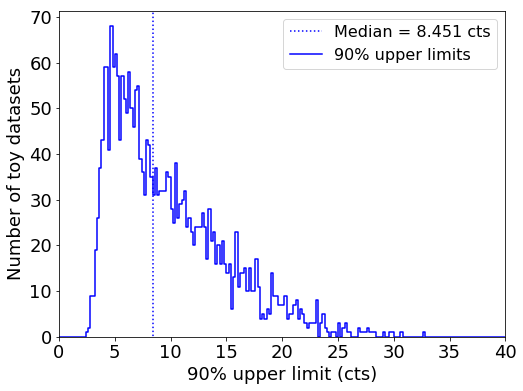

In [6]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (8,6)

hist = hl.hist(df['90CL_crossing'].loc[good_fit_mask], \
                        bins=np.linspace(0.,40.,201))

median = np.median(df['90CL_crossing'].loc[good_fit_mask])

hl.plot1d(hist,color='b',label='90% upper limits')

xvals = np.ones(10)*median
yvals = np.linspace(plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],10)

ylim = [0.,plt.gca().get_ylim()[1]]

plt.plot(xvals,yvals,':',label='Median = {:4.4} cts'.format(median))

plt.xlabel('90% upper limit (cts)')
plt.ylabel('Number of toy datasets')
plt.xlim(0.,40.)
plt.ylim(ylim[0],ylim[1])
plt.legend(loc='upper right',fontsize=16)


### Sensitivity as median of successive hypotheses

Another way to do this is to histogram the distribution of $q_\mu$ for each $\mu$ given a dataset with $\mu'=0$. Let's visualize this.

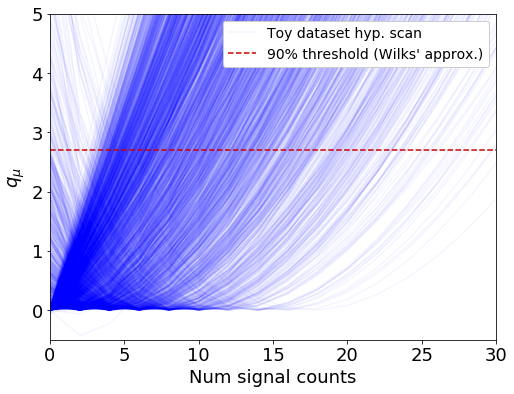

In [7]:
for index, row in df.iterrows():
    if index > 2500: break
        
    if not good_fit_mask[index]: continue
    #if good_fit_mask[index]: continue
        
    if index == 0:
        plt.plot(row['num_signal'],row['lambda'],color=(0.,0.,1.,0.04),label='Toy dataset hyp. scan')
    else:
        plt.plot(row['num_signal'],row['lambda'],color=(0.,0.,1.,0.04))
    
plt.xlim(0.,30.)
plt.ylim(-0.5,5.)

xvals = np.linspace(0.,50.,10)
yvals = np.ones(10)*2.706

plt.plot(xvals,yvals,'--',color=(0.8,0.,0.,1.),label='90% threshold (Wilks\' approx.)')

plt.xlabel('Num signal counts')
plt.ylabel(r'$q_\mu$')
plt.legend(loc='upper right',fontsize=14,framealpha=1.)
plt.savefig('Plots/asimov_study_toy_datasets_hypothesis_scans.png',dpi=200,bbox_inches='tight')

    

In [9]:
hypotheses = df['num_signal'].iloc[0]

lambdas_list = [[] for i in range(len(hypotheses))]

for index, row in df.iterrows():
    
    if not good_fit_mask[index]: 
        continue
        
    for i in range(len(hypotheses)):
        lambdas_list[i].append(row['lambda'][i])



In [10]:
qdist_list = []
qmedian_list = []
qmederr_list= []

for i in range(len(hypotheses)):
    qdist_list.append( hl.hist(lambdas_list[i],bins=np.linspace(0.,50.,500)) )
    qmedian_list.append( np.median(lambdas_list[i]) )
    qmederr_list.append( np.std(lambdas_list[i])/np.sqrt(len(lambdas_list[i])) )
    
    

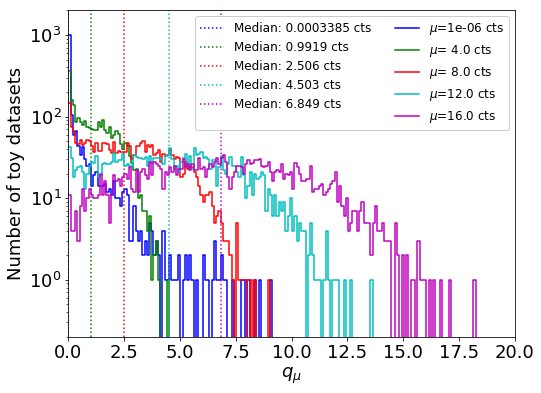

In [11]:
for i in range(5):
    idx = i*2
    hl.plot1d( qdist_list[idx],\
              label=r'$\mu$={:4.4} cts'.format(hypotheses[idx]),\
             color=colors[i])
    xvals = np.ones(10)*qmedian_list[idx]
    yvals = np.linspace(0.2,2.e3,10)
    plt.plot(xvals,yvals,':',\
             color=colors[i],label='Median: {:4.4} cts'.format(qmedian_list[idx]))
    
plt.legend(fontsize=12,ncol=2,framealpha=1)
plt.xlim(0.,20.)
plt.ylim(0.2,2.e3)
plt.yscale('log')
plt.xlabel(r'$q_\mu$')
plt.ylabel('Number of toy datasets')
plt.savefig('Plots/asimov_study_distributions_at_different_hypotheses.png',dpi=200,bbox_inches='tight')


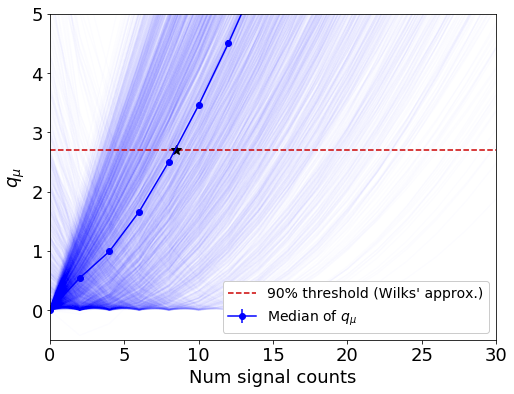

In [12]:
for index, row in df.iterrows():
    if index > 2500: break
        
    if not good_fit_mask[index]: continue
    #if good_fit_mask[index]: continue
        
    plt.plot(row['num_signal'],row['lambda'],color=(0.,0.,1.,0.01))
    
plt.xlim(0.,30.)
plt.ylim(-0.5,5.)

xvals = np.linspace(0.,50.,10)
yvals = np.ones(10)*2.706

plt.plot(xvals,yvals,'--',color=(0.8,0.,0.,1.),label='90% threshold (Wilks\' approx.)')

plt.xlabel('Num signal counts')
plt.ylabel(r'$q_\mu$')


plt.errorbar(hypotheses,qmedian_list,yerr=qmederr_list,\
             fmt='-o',label=r'Median of $q_\mu$',color='b')

plt.legend(loc='lower right',framealpha=1,fontsize=14)

plt.plot(median,2.706,'*',markersize=10,color='k')

plt.savefig('Plots/asimov_study_medians_at_different_hypotheses_with_toys.png',dpi=200,bbox_inches='tight')



Okay, so the blue curve is what we want to compare with a scan using the Asimov dataset. 


## Test out Asimov dataset code

In [8]:
workspace = nEXOFitWorkspace.nEXOFitWorkspace( \
                    config='../../config/Sensitivity2020_Optimized_DNN_Standoff_Binning_version1.yaml' )

workspace.LoadComponentsTableFromFile('/p/vast1/nexo/sensitivity2020/pdfs/component_tables/'+\
                    'ComponentsTable_D-023_Optimized_DNN_Standoff_Binning_version1_merged-v10b_AllCo60.h5')

workspace.CreateGroupedPDFs()





Loading input data froma previously-generated components table....

ERROR: The input file must be an HDF5 file.

File /p/vast1/nexo/sensitivity2020/pdfs/component_tables/ComponentsTable_D-023_Optimized_DNN_Standoff_Binning_version1_merged-v10b_AllCo60.h5 does not exist

Creating grouped PDFs....
	Group:                              	Expected Counts:
	nan                                 	            nan


In [14]:
likelihood = nEXOFitLikelihood.nEXOFitLikelihood()
likelihood.AddPDFDataframeToModel(workspace.df_group_pdfs,workspace.histogram_axis_names)
likelihood.model.GenerateModelDistribution()
likelihood.AddDataset( likelihood.model.GenerateDataset() )

ss_dict = { 'DNN':         [0.85,1.],
             'Energy (keV)':  [ 1000., 3500. ],  
             'Standoff (mm)': [ 0., 650. ] } 
ms_dict = { 'DNN':         [0.,0.85],
             'Energy (keV)':  [ 1000., 3500. ],  
             'Standoff (mm)': [ 0., 650. ] } 
ss_inner_dict = { 'DNN':         [0.85,1.],
             'Energy (keV)':  [ 1000., 3500. ],  
             'Standoff (mm)': [ 104., 650. ] } 
workspace.DefineROI( ss_dict )



DNN:
	Input ROI boundaries:      0.85,      1.0
	Actual ROI boundaries:     0.84,      1.0
Energy (keV):
	Input ROI boundaries:    1000.0,   3500.0
	Actual ROI boundaries:   1000.0,   3500.0
Standoff (mm):
	Input ROI boundaries:       0.0,    650.0
	Actual ROI boundaries:      0.0,    650.0


Plotting Far
Plotting VesselU238
Plotting VesselTh232
Plotting FullTPCCo60
Plotting InternalsU238
Plotting InternalsTh232
Plotting FullTPCK40
Plotting Rn222
Plotting B8nu
Plotting FullLXeBb2n
Plotting FullLXeBb0n
Plotting Xe137
Plotting Ar42
Plotting data...
DNN:
	Input cut boundaries:      0.85,      1.0
	Actual ROI boundaries:     0.84,      1.0
Energy (keV):
	Input cut boundaries:    1000.0,   3500.0
	Actual ROI boundaries:   1000.0,   3500.0
Standoff (mm):
	Input cut boundaries:       0.0,    650.0
	Actual ROI boundaries:      0.0,    650.0


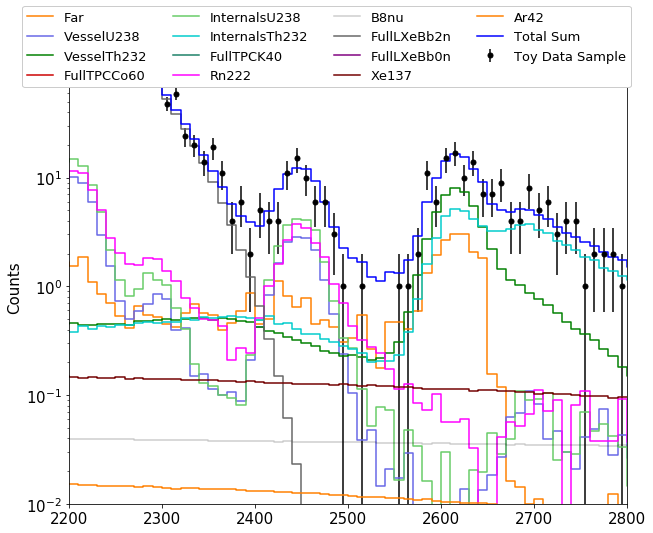

In [15]:

likelihood.PlotModelDistributionsSingleFrame(axis=1,cut_dict=ss_dict,\
                                             output_filename='Plots/asmiov_study_energy_spectrum_toy_data_zoomed.png',\
                                             data_markersize=5,\
                                             plot_data=True,save=True,\
                                             xrange=[2200.,2800.],\
                                            yrange=[0.01,100.])



Plotting Far
Plotting VesselU238
Plotting VesselTh232
Plotting FullTPCCo60
Plotting InternalsU238
Plotting InternalsTh232
Plotting FullTPCK40
Plotting Rn222
Plotting B8nu
Plotting FullLXeBb2n
Plotting FullLXeBb0n
Plotting Xe137
Plotting Ar42


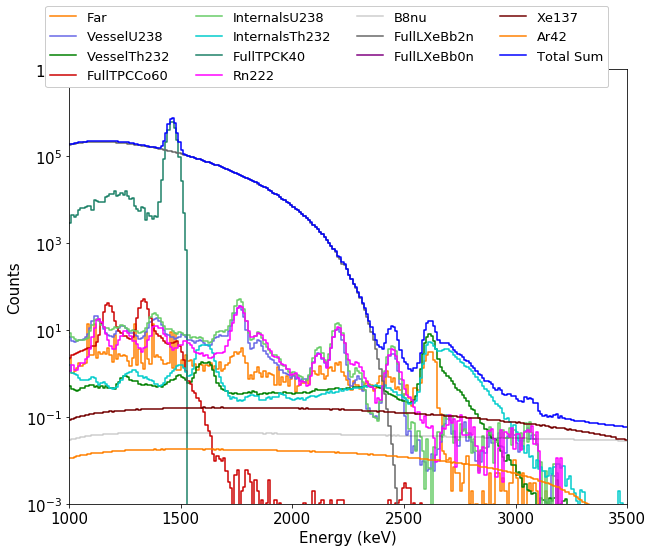

In [16]:
likelihood.PlotModelDistributionsSingleFrame(axis=1,cut_dict=ss_dict,\
                                             output_filename='Plots/asmiov_study_energy_spectrum_just_model.png',\
                                             data_markersize=2,\
                                             plot_data=False,save=True,yrange=[1.e-3,1.e7])



DNN:
	Input ROI boundaries:      0.85,      1.0
	Actual ROI boundaries:     0.84,      1.0
Energy (keV):
	Input ROI boundaries:    1000.0,   3500.0
	Actual ROI boundaries:   1000.0,   3500.0
Standoff (mm):
	Input ROI boundaries:       0.0,    650.0
	Actual ROI boundaries:      0.0,    650.0
Plotting Far
Plotting VesselU238
Plotting VesselTh232
Plotting FullTPCCo60
Plotting InternalsU238
Plotting InternalsTh232
Plotting FullTPCK40
Plotting Rn222
Plotting B8nu
Plotting FullLXeBb2n
Plotting FullLXeBb0n
Plotting Xe137
Plotting Ar42
Plotting data...
DNN:
	Input cut boundaries:      0.85,      1.0
	Actual ROI boundaries:     0.84,      1.0
Energy (keV):
	Input cut boundaries:    1000.0,   3500.0
	Actual ROI boundaries:   1000.0,   3500.0
Standoff (mm):
	Input cut boundaries:       0.0,    650.0
	Actual ROI boundaries:      0.0,    650.0


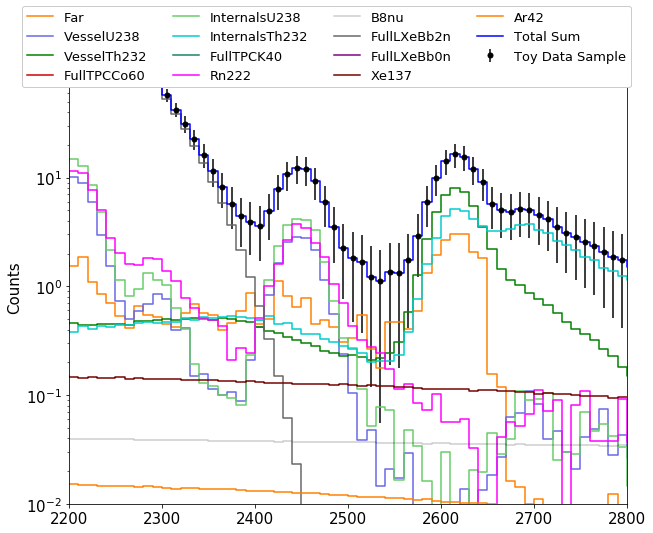

In [17]:
likelihood = nEXOFitLikelihood.nEXOFitLikelihood()
likelihood.AddPDFDataframeToModel(workspace.df_group_pdfs,workspace.histogram_axis_names)
likelihood.model.GenerateModelDistribution()

ss_dict = { 'DNN':         [0.85,1.],
             'Energy (keV)':  [ 1000., 3500. ],  
             'Standoff (mm)': [ 0., 650. ] } 
ms_dict = { 'DNN':         [0.,0.85],
             'Energy (keV)':  [ 1000., 3500. ],  
             'Standoff (mm)': [ 0., 650. ] } 
workspace.DefineROI( ss_dict )



likelihood.AddDataset( likelihood.model.GenerateAsimovDataset() )

likelihood.PlotModelDistributionsSingleFrame(axis=1,cut_dict=ss_dict,\
                                             output_filename='Plots/asmiov_study_energy_spectrum_asmimov_data_zoomed.png',\
                                             data_markersize=5,\
                                             plot_data=True,save=True,\
                                             xrange=[2200.,2800.],\
                                            yrange=[0.01,100.])



Okay, so this seems to work fine. Next, let's see if we can.

## Computing $q_\mu$ as a function of $\mu$ with $\mu'=0$

To do this, we'll do only a single hypothesis scan. It's important that we still do a fit at each step, since the nuisance parameters need to be allowed to vary.

In [18]:
likelihood = nEXOFitLikelihood.nEXOFitLikelihood()
likelihood.AddPDFDataframeToModel(workspace.df_group_pdfs,workspace.histogram_axis_names)
likelihood.model.GenerateModelDistribution()

likelihood.AddDataset( likelihood.model.GenerateAsimovDataset() )

for var in likelihood.model.variable_list:
    if 'Bb0n' in var['Name']:
        likelihood.SetVariableLimits( var['Name'], \
                                  lower_limit = -15., \
                                  upper_limit = 100.)
    elif 'Background_Shape_Error' in var['Name']:
        likelihood.SetVariableLimits( var['Name'], \
                                  lower_limit = -100., \
                                  upper_limit = 100.)
    else: 
        likelihood.SetVariableLimits( var['Name'], \
                                  lower_limit = var['Value']*0.05, \
                                  upper_limit = var['Value']*10.)

likelihood.SetFractionalMinuitInputError('Num_FullLXeBb0n', 0.01/0.0001)



In [19]:
likelihood.SetAllVariablesFloating()

initial_guess = likelihood.GetVariableValues()

rn222_idx = likelihood.model.GetVariableIndexByName('Rn222')
# Fluctuate Rn222 constraint
rn222_constraint_val = (np.random.randn()*0.1 + 1)*initial_guess[rn222_idx]
# Set Rn222 constraint
likelihood.SetGaussianConstraintAbsolute(likelihood.model.variable_list[rn222_idx]['Name'],\
                                         rn222_constraint_val, \
                                         0.1 * initial_guess[rn222_idx])

likelihood.PrintVariableList()

print('\nConstraints:')
for constraint in likelihood.model.constraints:
        print('\t{}'.format(constraint))
print('\n')

                

Variable name:          Value:       IsFixed:  FitError   InputError:   IsConstrained: Limits:      
Num_Far                 5.073e+03    False     None       71.23         False          (253.66566987385232,50733.13397477046)
Num_Vessel_U238         1.723e+04    False     None       131.3         False          (861.4239770976851,172284.795419537)
Num_Vessel_Th232        2.748e+03    False     None       52.43         False          (137.41960766579805,27483.92153315961)
Num_FullTPC_Co60        1.217e+04    False     None       110.3         False          (608.5822401745211,121716.4480349042)
Num_Internals_U238      2.378e+04    False     None       154.2         False          (1189.091323492539,237818.2646985078)
Num_Internals_Th232     4.807e+03    False     None       69.33         False          (240.34998923646705,48069.99784729341)
Num_FullTPC_K40         4.079e+07    False     None       6.387e+03     False          (2039689.7725368333,407937954.50736666)
Num_Rn222           

In [20]:
lambdas = np.zeros(len(hypotheses))
num_iterations = np.ones(len(hypotheses))
xvals = np.zeros(len(hypotheses))
fixed_fit_converged = np.array([],dtype=bool)
fixed_fit_covar = np.array([],dtype=bool)





for i in range(len(hypotheses)):
    sig_idx = likelihood.GetVariableIndex('Bb0n')
    initial_values = np.copy(initial_guess)
    initial_values[sig_idx] = hypotheses[i]
    
    ###########################################################################
    # All the exciting stuff happens here!
    lambda_fit_result = likelihood.ComputeLambdaForPositiveSignal(\
                                                    initial_values=initial_values,\
                                                    signal_name='Bb0n',\
                                                    signal_expectation=0.,\
                                                    print_level=0,\
                                                    fixed_fit_signal_value=hypotheses[i])
    ###########################################################################

    lambdas[i] = lambda_fit_result['lambda']
    fixed_fit_converged = np.append(fixed_fit_converged, lambda_fit_result['fixed_fit_converged'])
    fixed_fit_covar = np.append(fixed_fit_covar, lambda_fit_result['fixed_fit_covar'])
    num_iterations[i] = lambda_fit_result['fixed_fit_iterations']
    
    best_fit_converged = lambda_fit_result['best_fit_converged']
    best_fit_covar = lambda_fit_result['best_fit_covar']
    best_fit_iterations = lambda_fit_result['best_fit_iterations']
    
    print('After fit ends:')
    likelihood.PrintVariableList()
    print('\n')
    
    
    
    
    


Running best fit...

Best fit result NLL: 0.03878
Best fit signal value is less than 0! Fixing value to 0 and re-running fit...
Zero fit result NLL: 0.0388


Fit with Num_FullLXeBb0n fixed at 1e-06 cts...

Zero fit result NLL: 0.0388
After fit ends:
Variable name:          Value:       IsFixed:  FitError   InputError:   IsConstrained: Limits:      
Num_Far                 5.04e+03     False     505.       71.23         False          (253.66566987385232,50733.13397477046)
Num_Vessel_U238         1.738e+04    False     2764       131.3         False          (861.4239770976851,172284.795419537)
Num_Vessel_Th232        2.755e+03    False     124.       52.43         False          (137.41960766579805,27483.92153315961)
Num_FullTPC_Co60        1.216e+04    False     407.       110.3         False          (608.5822401745211,121716.4480349042)
Num_Internals_U238      2.349e+04    False     2868       154.2         False          (1189.091323492539,237818.2646985078)
Num_Internals_Th232   

Zero fit result NLL: 0.0388
After fit ends:
Variable name:          Value:       IsFixed:  FitError   InputError:   IsConstrained: Limits:      
Num_Far                 5.033e+03    False     641.       71.23         False          (253.66566987385232,50733.13397477046)
Num_Vessel_U238         1.738e+04    False     496.       131.3         False          (861.4239770976851,172284.795419537)
Num_Vessel_Th232        2.755e+03    False     212.       52.43         False          (137.41960766579805,27483.92153315961)
Num_FullTPC_Co60        1.216e+04    False     388.       110.3         False          (608.5822401745211,121716.4480349042)
Num_Internals_U238      2.343e+04    False     543.       154.2         False          (1189.091323492539,237818.2646985078)
Num_Internals_Th232     4.807e+03    False     150.       69.33         False          (240.34998923646705,48069.99784729341)
Num_FullTPC_K40         4.079e+07    False     6369       6.387e+03     False          (2039689.7725368

Zero fit result NLL: 0.0388
After fit ends:
Variable name:          Value:       IsFixed:  FitError   InputError:   IsConstrained: Limits:      
Num_Far                 5.026e+03    False     758.       71.23         False          (253.66566987385232,50733.13397477046)
Num_Vessel_U238         1.725e+04    False     1690       131.3         False          (861.4239770976851,172284.795419537)
Num_Vessel_Th232        2.756e+03    False     262.       52.43         False          (137.41960766579805,27483.92153315961)
Num_FullTPC_Co60        1.216e+04    False     389.       110.3         False          (608.5822401745211,121716.4480349042)
Num_Internals_U238      2.352e+04    False     1224       154.2         False          (1189.091323492539,237818.2646985078)
Num_Internals_Th232     4.808e+03    False     163.       69.33         False          (240.34998923646705,48069.99784729341)
Num_FullTPC_K40         4.079e+07    False     6528       6.387e+03     False          (2039689.7725368

Zero fit result NLL: 0.0388
After fit ends:
Variable name:          Value:       IsFixed:  FitError   InputError:   IsConstrained: Limits:      
Num_Far                 5.012e+03    False     609.       71.23         False          (253.66566987385232,50733.13397477046)
Num_Vessel_U238         1.723e+04    False     1820       131.3         False          (861.4239770976851,172284.795419537)
Num_Vessel_Th232        2.759e+03    False     202.       52.43         False          (137.41960766579805,27483.92153315961)
Num_FullTPC_Co60        1.216e+04    False     398.       110.3         False          (608.5822401745211,121716.4480349042)
Num_Internals_U238      2.352e+04    False     2195       154.2         False          (1189.091323492539,237818.2646985078)
Num_Internals_Th232     4.808e+03    False     151.       69.33         False          (240.34998923646705,48069.99784729341)
Num_FullTPC_K40         4.079e+07    False     6525       6.387e+03     False          (2039689.7725368

Zero fit result NLL: 0.0388
After fit ends:
Variable name:          Value:       IsFixed:  FitError   InputError:   IsConstrained: Limits:      
Num_Far                 4.999e+03    False     671.       71.23         False          (253.66566987385232,50733.13397477046)
Num_Vessel_U238         1.718e+04    False     2760       131.3         False          (861.4239770976851,172284.795419537)
Num_Vessel_Th232        2.762e+03    False     212.       52.43         False          (137.41960766579805,27483.92153315961)
Num_FullTPC_Co60        1.216e+04    False     416.       110.3         False          (608.5822401745211,121716.4480349042)
Num_Internals_U238      2.355e+04    False     2872       154.2         False          (1189.091323492539,237818.2646985078)
Num_Internals_Th232     4.807e+03    False     147.       69.33         False          (240.34998923646705,48069.99784729341)
Num_FullTPC_K40         4.079e+07    False     6523       6.387e+03     False          (2039689.7725368

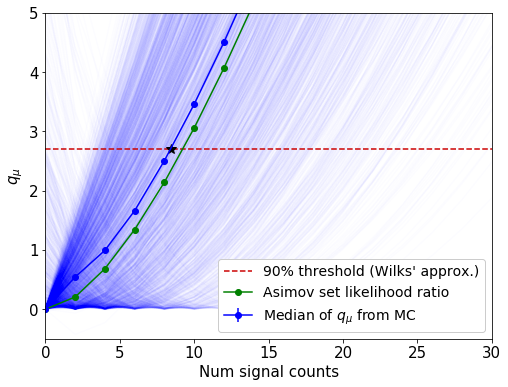

In [21]:
for index, row in df.iterrows():
    if index > 2500: break
        
    if not good_fit_mask[index]: continue
    #if good_fit_mask[index]: continue
        
    plt.plot(row['num_signal'],row['lambda'],color=(0.,0.,1.,0.01))
    
plt.xlim(0.,30.)
plt.ylim(-0.5,5.)

xvals = np.linspace(0.,50.,10)
yvals = np.ones(10)*2.706

plt.plot(xvals,yvals,'--',color=(0.8,0.,0.,1.),label='90% threshold (Wilks\' approx.)')
plt.plot(hypotheses,lambdas,'-og',label='Asimov set likelihood ratio')

plt.xlabel('Num signal counts')
plt.ylabel(r'$q_\mu$')


plt.errorbar(hypotheses,qmedian_list,yerr=qmederr_list,\
             fmt='-o',label=r'Median of $q_\mu$ from MC',color='b')

plt.legend(loc='lower right',framealpha=1,fontsize=14)

plt.plot(median,2.706,'*',markersize=10,color='k')

plt.savefig('Plots/asimov_study_hypothesis_scan_with_asimov_set.png',dpi=200,bbox_inches='tight')




[ 0.01505006  0.176132   -0.23338038]


(-0.5, 5.0)

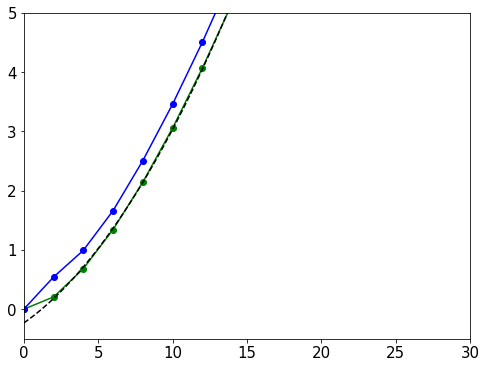

In [22]:
# What is the sensitivty using the Asimov set?
p = np.polyfit(hypotheses[1:8],lambdas[1:8],2)

print(p)

plt.errorbar(hypotheses,qmedian_list,yerr=qmederr_list,\
             fmt='-o',label=r'Median of $q_\mu$ from MC',color='b')
plt.plot(hypotheses,lambdas,'-og',label='Asimov set likelihood ratio')

xvals = np.linspace(0.,30.,20000)
yvals = p[0]*xvals**2 + p[1]*xvals + p[2]

plt.plot(xvals,yvals,'--k')
plt.xlim(0.,30.)
plt.ylim(-0.5,5.)







In [23]:
idx = np.where(yvals > 2.706)[0][0]
print(xvals[idx])

print('Sensitivity of Asimov set is worse by: {:4.4}'.format(1/median / (1/xvals[idx])))
print((xvals[idx]-median)/median)

9.300465023251162
Sensitivity of Asimov set is worse by: 1.101
0.10053668363891556


## What if I fix all the parameters, and just calculate the likelihood at each point.

In [24]:
likelihood = nEXOFitLikelihood.nEXOFitLikelihood()
likelihood.AddPDFDataframeToModel(workspace.df_group_pdfs,workspace.histogram_axis_names)
likelihood.model.GenerateModelDistribution()

likelihood.AddDataset( likelihood.model.GenerateAsimovDataset() )

for var in likelihood.model.variable_list:
    if 'Bb0n' in var['Name']:
        likelihood.SetVariableLimits( var['Name'], \
                                  lower_limit = -15., \
                                  upper_limit = 100.)
    elif 'Background_Shape_Error' in var['Name']:
        likelihood.SetVariableLimits( var['Name'], \
                                  lower_limit = -100., \
                                  upper_limit = 100.)
    else: 
        likelihood.SetVariableLimits( var['Name'], \
                                  lower_limit = var['Value']*0.05, \
                                  upper_limit = var['Value']*10.)
        
    if not 'Bb2n'in var['Name']:
        likelihood.SetVariableFixStatus(var['Name'],True)

likelihood.SetFractionalMinuitInputError('Num_FullLXeBb0n', 0.01/0.0001)

In [25]:
initial_guess = likelihood.GetVariableValues()

rn222_idx = likelihood.model.GetVariableIndexByName('Rn222')
# Fluctuate Rn222 constraint
rn222_constraint_val = (np.random.randn()*0.1 + 1)*initial_guess[rn222_idx]
# Set Rn222 constraint
likelihood.SetGaussianConstraintAbsolute(likelihood.model.variable_list[rn222_idx]['Name'],\
                                         rn222_constraint_val, \
                                         0.1 * initial_guess[rn222_idx])

likelihood.PrintVariableList()

print('\nConstraints:')
for constraint in likelihood.model.constraints:
        print('\t{}'.format(constraint))
print('\n')

Variable name:          Value:       IsFixed:  FitError   InputError:   IsConstrained: Limits:      
Num_Far                 5.073e+03    True      None       71.23         False          (253.66566987385232,50733.13397477046)
Num_Vessel_U238         1.723e+04    True      None       131.3         False          (861.4239770976851,172284.795419537)
Num_Vessel_Th232        2.748e+03    True      None       52.43         False          (137.41960766579805,27483.92153315961)
Num_FullTPC_Co60        1.217e+04    True      None       110.3         False          (608.5822401745211,121716.4480349042)
Num_Internals_U238      2.378e+04    True      None       154.2         False          (1189.091323492539,237818.2646985078)
Num_Internals_Th232     4.807e+03    True      None       69.33         False          (240.34998923646705,48069.99784729341)
Num_FullTPC_K40         4.079e+07    True      None       6.387e+03     False          (2039689.7725368333,407937954.50736666)
Num_Rn222           

In [26]:
lambdas = np.zeros(len(hypotheses))
num_iterations = np.ones(len(hypotheses))
xvals = np.zeros(len(hypotheses))
fixed_fit_converged = np.array([],dtype=bool)
fixed_fit_covar = np.array([],dtype=bool)





for i in range(len(hypotheses)):
    sig_idx = likelihood.GetVariableIndex('Bb0n')
    initial_values = np.copy(initial_guess)
    initial_values[sig_idx] = hypotheses[i]
    
    ###########################################################################
    # All the exciting stuff happens here!
    lambda_fit_result = likelihood.ComputeLambdaForPositiveSignal(\
                                                    initial_values=initial_values,\
                                                    signal_name='Bb0n',\
                                                    signal_expectation=0.,\
                                                    print_level=0,\
                                                    fixed_fit_signal_value=hypotheses[i])
    ###########################################################################

    lambdas[i] = lambda_fit_result['lambda']
    fixed_fit_converged = np.append(fixed_fit_converged, lambda_fit_result['fixed_fit_converged'])
    fixed_fit_covar = np.append(fixed_fit_covar, lambda_fit_result['fixed_fit_covar'])
    num_iterations[i] = lambda_fit_result['fixed_fit_iterations']
    
    best_fit_converged = lambda_fit_result['best_fit_converged']
    best_fit_covar = lambda_fit_result['best_fit_covar']
    best_fit_iterations = lambda_fit_result['best_fit_iterations']
    
#     print('After fit ends:')
#     likelihood.PrintVariableList()
#     print('\n')
    
    
    
    


Running best fit...

Best fit result NLL: 0.4568
Best fit signal value is less than 0! Fixing value to 0 and re-running fit...
Zero fit result NLL: 0.4568


Fit with Num_FullLXeBb0n fixed at 1e-06 cts...

Zero fit result NLL: 0.4568


Fit with Num_FullLXeBb0n fixed at 2.0 cts...

Zero fit result NLL: 0.4568


Fit with Num_FullLXeBb0n fixed at 4.0 cts...

Zero fit result NLL: 0.4568


Fit with Num_FullLXeBb0n fixed at 6.0 cts...

Zero fit result NLL: 0.4568


Fit with Num_FullLXeBb0n fixed at 8.0 cts...

Zero fit result NLL: 0.4568


Fit with Num_FullLXeBb0n fixed at 10.0 cts...

Zero fit result NLL: 0.4568


Fit with Num_FullLXeBb0n fixed at 12.0 cts...

Zero fit result NLL: 0.4568


Fit with Num_FullLXeBb0n fixed at 14.0 cts...

Zero fit result NLL: 0.4568


Fit with Num_FullLXeBb0n fixed at 16.0 cts...

Zero fit result NLL: 0.4568


Fit with Num_FullLXeBb0n fixed at 18.0 cts...

Zero fit result NLL: 0.4568


Fit with Num_FullLXeBb0n fixed at 20.0 cts...

Zero fit result NLL: 0.4568


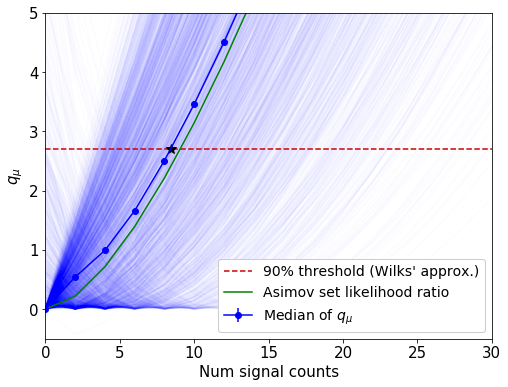

In [27]:
for index, row in df.iterrows():
    if index > 2500: break
        
    if not good_fit_mask[index]: continue
    #if good_fit_mask[index]: continue
        
    plt.plot(row['num_signal'],row['lambda'],color=(0.,0.,1.,0.01))
    
plt.xlim(0.,30.)
plt.ylim(-0.5,5.)

xvals = np.linspace(0.,50.,10)
yvals = np.ones(10)*2.706

plt.plot(xvals,yvals,'--',color=(0.8,0.,0.,1.),label='90% threshold (Wilks\' approx.)')
plt.plot(hypotheses,lambdas,'-g',label='Asimov set likelihood ratio')

plt.xlabel('Num signal counts')
plt.ylabel(r'$q_\mu$')


plt.errorbar(hypotheses,qmedian_list,yerr=qmederr_list,\
             fmt='-o',label=r'Median of $q_\mu$',color='b')

plt.legend(loc='lower right',framealpha=1,fontsize=14)

plt.plot(median,2.706,'*',markersize=10,color='k')